In [1]:
RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    %pip install bmtool &> /dev/null

In [2]:
import numpy as np
from scipy import signal as ss
import matplotlib.pyplot as plt
from bmtool.analysis.lfp import fit_fooof, calculate_spike_lfp_plv, calculate_ppc, calculate_ppc2

In [3]:
np.random.seed(9) # lucky number 9
fs = 1000  # 1 kHz sampling rate
duration = 200  # 200 seconds
t = np.arange(0, duration, 1/fs)

# Define oscillation frequencies
beta_freq = 15  # Hz
gamma_freq = 40  # Hz

# Create a simulated LFP with multiple frequency components
lfp = (0.5 * np.sin(2 * np.pi * gamma_freq * t) + 0.2 * np.sin(2 * np.pi * beta_freq * t) +  0.3 * np.random.randn(len(t)))

# Generate phase information for each frequency
beta_phase = np.angle(ss.hilbert(np.sin(2 * np.pi * beta_freq * t)))
gamma_phase = np.angle(ss.hilbert(np.sin(2 * np.pi * gamma_freq * t)))

# Generate beta-synchronized spikes
# Strong preference for specific beta phase, weak response to gamma
beta_spike_probability = (0.8 * (1 + np.cos(beta_phase - np.pi/4)) + 
                            0.1 * (1 + np.cos(gamma_phase - np.pi/3)))

beta_spike_train = np.random.rand(len(t)) < beta_spike_probability * 0.02
beta_spike_times = t[beta_spike_train]

# Generate gamma-synchronized spikes
# Strong preference for specific gamma phase, weak response to beta
gamma_spike_probability = (0.1 * (1 + np.cos(beta_phase - np.pi/4)) + 
                            0.8 * (1 + np.cos(gamma_phase - np.pi/3)))

gamma_spike_train = np.random.rand(len(t)) < gamma_spike_probability * 0.02
gamma_spike_times = t[gamma_spike_train]

print(f"Generated {len(beta_spike_times)} beta-synchronized spikes")
print(f"Generated {len(gamma_spike_times)} gamma-synchronized spikes")

Generated 3596 beta-synchronized spikes
Generated 3661 gamma-synchronized spikes


### We can see that we generated an LFP with two different frequencies

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 98 Hz                        
                                 Frequency Resolution is 3.91 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -3.8986, -0.0807                                         
                                                                                                  
                                       2 peaks were found:                                        
          

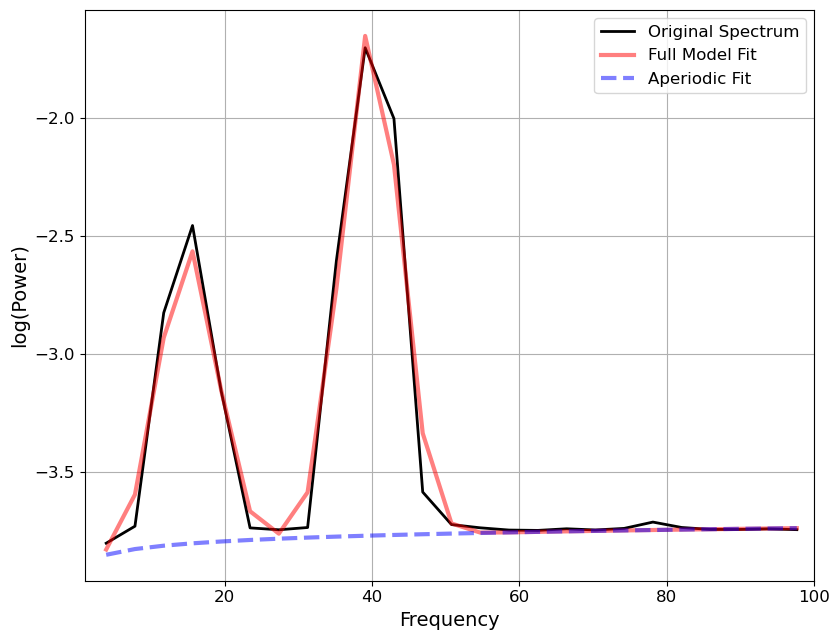

In [4]:
hz,pxx = ss.welch(lfp,fs)
_,_ = fit_fooof(hz,pxx,plot=True,report=True,plt_range=(1,100),freq_range=[1,100])

### Now we can see how our spike times are entrained to the lfp we made. There are a few different metrics that we can use.
### 1. Phase-Locking Value (PLV) - `calculate_spike_lfp_plv`
**Equation**:
$$
\text{PLV} = \frac{\left|\sum_{j=1}^{n} e^{i\phi_j}\right|^2}{n^2}
$$

Where:
- $\phi_j$ = Phase of LFP at spike time $j$
- $n$ = Number of spikes
- $i$ = Imaginary unit

This measures phase concentration by calculating the squared magnitude of the normalized resultant vector of spike-phase angles.

---

### 2. Pairwise Phase Consistency (PPC) - `calculate_ppc`
**Equation**:
$$
\text{PPC} = \frac{2}{n(n-1)} \sum_{j=1}^{n-1} \sum_{k=j+1}^{n} \cos(\phi_j - \phi_k)
$$

Where:
- $\phi_j,\phi_k$ = Phases at spike times $j$ and $k$
- $n$ = Number of spikes

This calculates phase consistency through pairwise comparisons of spike-phase differences.

---

### 3. Optimized Pairwise Phase Consistency (PPC2) - `calculate_ppc2`
### **Derivation of PPC2 from PPC**  

#### **1. Original PPC**  
$$
\text{PPC} = \frac{2}{n(n-1)} \sum_{i < j} \cos(\phi_i - \phi_j)
$$

#### **2. Rewrite $\cos(\phi_i - \phi_j)$ Using Euler’s Formula**  
$$
\cos(\phi_i - \phi_j) = \text{Re}\left( e^{i(\phi_i - \phi_j)} \right)
$$

#### **3. Sum Over All Pairs**  
$$
\sum_{i < j} \cos(\phi_i - \phi_j) = \frac{1}{2} \sum_{i=1}^n \sum_{j=1}^n \cos(\phi_i - \phi_j) - \frac{n}{2}
$$

#### **4. Express in Terms of Complex Exponentials**  
$$
\sum_{i < j} \cos(\phi_i - \phi_j) = \frac{1}{2} \text{Re} \left( \left| \sum_{j=1}^n e^{i\phi_j} \right|^2 \right) - \frac{n}{2}
$$

#### **5. Final PPC2 Formula**
$$
\text{PPC2} = \frac{\left|\sum_{j=1}^{n} e^{i\phi_j}\right|^2 - n}{n(n-1)}
$$

This algebraic equivalent of PPC provides computational optimization by:
1. Converting phases to complex unit vectors
2. Using vector magnitude properties to avoid explicit pairwise comparisons

All three metrics quantify phase locking between spike times and LFP oscillations
- all metrics should be the same with enough spike times

In [5]:
# spikes were generated on second time scale so spike_fs=1
print(calculate_spike_lfp_plv(spike_times=gamma_spike_times, lfp_signal=lfp,spike_fs=1, lfp_fs=fs, method='wavelet',freq_of_interest=40))
print(calculate_ppc(spike_times=gamma_spike_times, lfp_signal=lfp,spike_fs=1, lfp_fs=fs, method='wavelet',freq_of_interest=40))
print(calculate_ppc(spike_times=gamma_spike_times, lfp_signal=lfp,spike_fs=1, lfp_fs=fs, method='wavelet',freq_of_interest=40,slow_way=True))
print(calculate_ppc2(spike_times=gamma_spike_times, lfp_signal=lfp,spike_fs=1, lfp_fs=fs, method='wavelet',freq_of_interest=40))

0.18112236611123156
Note this method will a very long time if there are a lot of spikes. If there are a lot of spikes consider using the PPC2 method if speed is an issue
0.18089862905279205
Note this method will a very long time if there are a lot of spikes. If there are a lot of spikes consider using the PPC2 method if speed is an issue
0.18089862905277534
0.18089862905279203


### We can also check the entrainment at different frequencies 

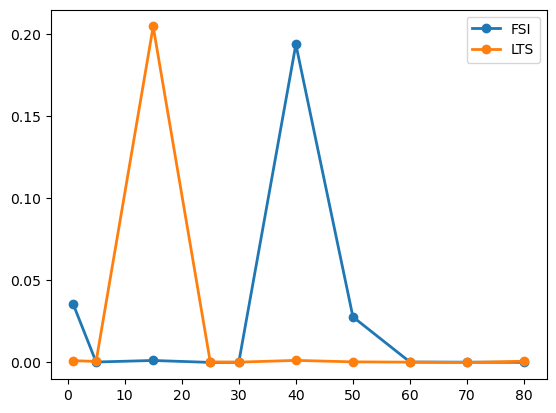

In [5]:
freqs = [1,5,15,25,30,40,50,60,70,80]
ppc_gamma = []
ppc_beta = []

for i in range(len(freqs)):
    ppc_gamma.append(calculate_ppc2(spike_times=gamma_spike_times, lfp_signal=lfp,spike_fs=1, lfp_fs=fs, method='wavelet',freq_of_interest=freqs[i]))
    ppc_beta.append(calculate_ppc2(spike_times=beta_spike_times, lfp_signal=lfp,spike_fs=1, lfp_fs=fs, method='wavelet',freq_of_interest=freqs[i]))
    
plt.plot(freqs,ppc_gamma,'o-', linewidth=2,label="FSI")
plt.plot(freqs,ppc_beta,'o-', linewidth=2,label='LTS')
plt.legend()
plt.show()